#Red Blood Cell Segmentation and Classification

##1. RBC Segmentation

Import OpenCV, Numpy and Matplotlib

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

Load and display image

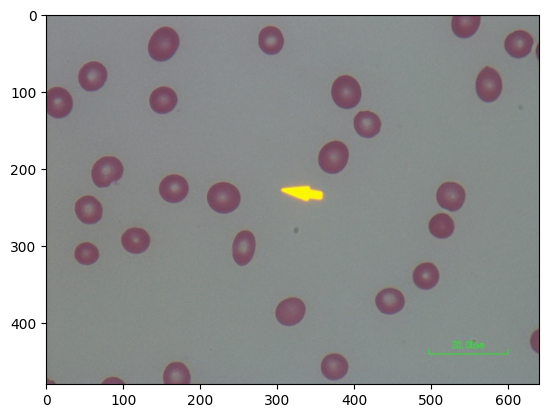

In [ ]:
inputImage = cv2.imread("rbc.jpg")
inputImageRGB = cv2.cvtColor(inputImage,cv2.COLOR_BGR2RGB)

plt.imshow(inputImageRGB)
plt.show()

convert to grayscale

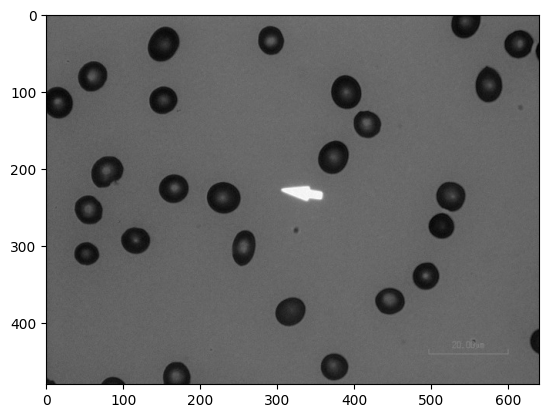

In [ ]:
inputImageGray = cv2.cvtColor(inputImage,cv2.COLOR_BGR2GRAY)
plt.imshow(inputImageGray,cmap = 'gray')
plt.show()

preprocess image

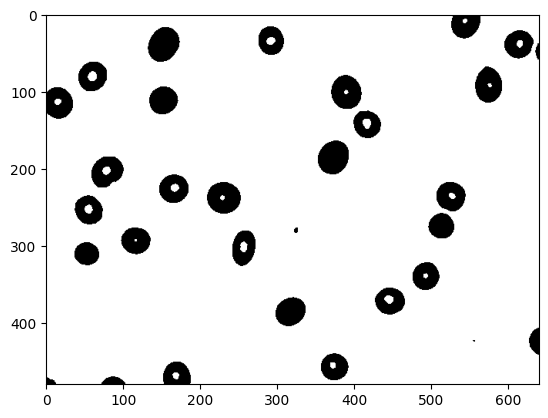

In [ ]:
clahe = cv2.createCLAHE(clipLimit = 3.0, tileGridSize = (8,8))
greyImage = clahe.apply(inputImageGray)
blur = cv2.GaussianBlur(greyImage,(3,3),0)
ret,threshold_image = cv2.threshold(blur,0,255,cv2.THRESH_OTSU)
plt.imshow(threshold_image,cmap = 'gray')
plt.show()

invert image

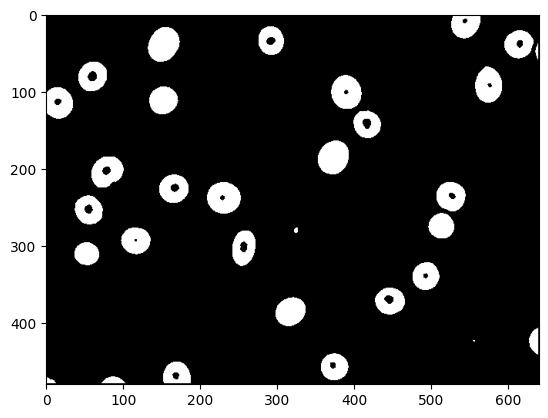

In [ ]:
cv2.bitwise_not(threshold_image,threshold_image)
x,y = threshold_image.shape
threshold_image[0,:] = 0
threshold_image[:,0] = 0
threshold_image[x-1,:] = 0
threshold_image[:,y-1] = 0
plt.imshow(threshold_image,cmap = 'gray')
plt.show()

find red blood cell contours

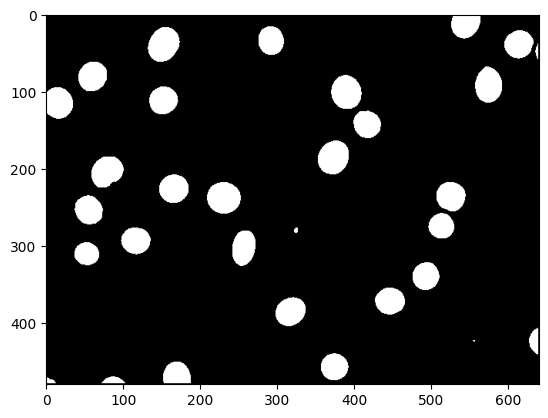

In [ ]:
contours,hierarchy  = cv2.findContours(threshold_image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
filled_image = np.zeros_like(threshold_image)
cv2.fillPoly(filled_image, contours, color=(255,255,255))
plt.imshow(filled_image,cmap = 'gray')
plt.show()

##2. Preprocessing for Deep Learning

Extract each red blood cell to an image

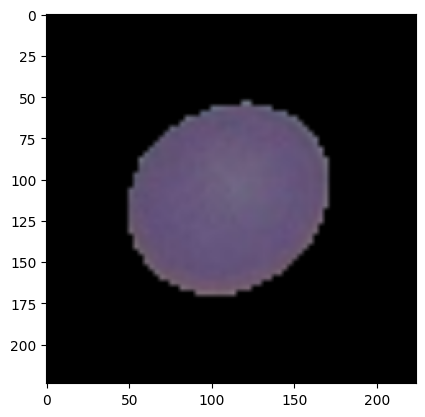

In [ ]:
single_cell_images = []
center_cells = []
for c in contours:
  if cv2.contourArea(c) < 500:
    continue

  imageTemp = np.zeros_like(threshold_image)

  cv2.fillPoly(imageTemp, [c], color=(255,255,255))
  imageTemp = cv2.bitwise_and(inputImage,inputImage,mask = imageTemp)
  M = cv2.moments(c)
  center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

  # centering the cell on image
  middleX = center[1]
  middleY = center[0]
  x0 = middleX-35
  x1 = middleX+37
  y0 = middleY-35
  y1 = middleY+37
  if x0 < 0 :
      x1 += abs(x0)
      x0 = 0
  elif x1>480:
      x0 -= x1%480
      x1 = 480
  if y0 < 0 :
      y1 += abs(y0)
      y0 = 0
  elif y1 >640 :
      y0 -= y1%640
      y1 = 640


  image = imageTemp[x0:x1,y0:y1]
  image = cv2.resize(image, (224,224))
  single_cell_images.append(image)
  center_cells.append(center)

plt.imshow(single_cell_images[2])
plt.show()


##3. Loading and Using a Pre-trained Model

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.5 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=ab3901c1e161cec330eb27180521e53a306677c74d13d67f80

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:07<00:00, 4.12MB/s]


Loaded pretrained weights for efficientnet-b1


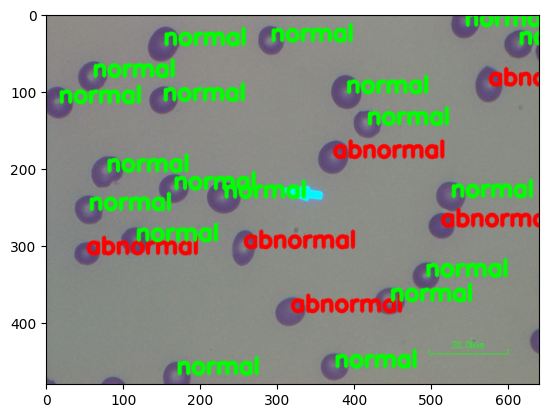

In [ ]:
import torch
from efficientnet_pytorch import EfficientNet

model_ft = EfficientNet.from_pretrained('efficientnet-b1', num_classes=12)
model_ft.load_state_dict(torch.load('rbc_efficientnetb1',map_location='cpu'))
model_ft.eval()

outputimage = inputImage.copy()

for single_cell_image, center in zip(single_cell_images, center_cells):
  image = single_cell_image.astype(float)/255
  image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
  image = torch.from_numpy(image).float().permute(2,0,1).unsqueeze(0)

  with torch.no_grad():
    predoutput = model_ft(image)
    _, preds = torch.max(predoutput, 1)
    if preds == 0:
      outputimage = cv2.putText(outputimage, 'normal', center, cv2.FONT_HERSHEY_SIMPLEX, 1,
              (0,255,0), 3, cv2.LINE_AA, False)
    else:
      outputimage = cv2.putText(outputimage, 'abnormal', center, cv2.FONT_HERSHEY_SIMPLEX, 1,
              (255,0,0), 3, cv2.LINE_AA, False)

plt.imshow(outputimage)
plt.show()

##4. Summary Code Block

Loaded pretrained weights for efficientnet-b1


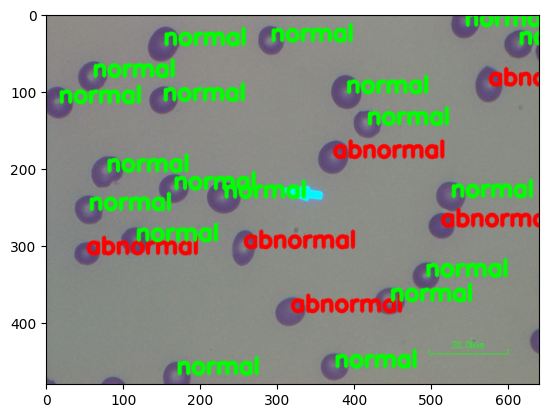

In [ ]:
inputImage = cv2.imread("rbc.jpg")
inputImageGray = cv2.cvtColor(inputImage,cv2.COLOR_BGR2GRAY)

clahe = cv2.createCLAHE(clipLimit = 3.0, tileGridSize = (8,8))
greyImage = clahe.apply(inputImageGray)
blur = cv2.GaussianBlur(greyImage,(3,3),0)
ret,threshold_image = cv2.threshold(blur,0,255,cv2.THRESH_OTSU)
cv2.bitwise_not(threshold_image,threshold_image)
x,y = threshold_image.shape
threshold_image[0,:] = 0
threshold_image[:,0] = 0
threshold_image[x-1,:] = 0
threshold_image[:,y-1] = 0

contours,hierarchy  = cv2.findContours(threshold_image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
filled_image = np.zeros_like(threshold_image)
cv2.fillPoly(filled_image, contours, color=(255,255,255))

single_cell_images = []
center_cells = []
for c in contours:
  if cv2.contourArea(c) < 500:
    continue

  imageTemp = np.zeros_like(threshold_image)

  cv2.fillPoly(imageTemp, [c], color=(255,255,255))
  imageTemp = cv2.bitwise_and(inputImage,inputImage,mask = imageTemp)
  M = cv2.moments(c)
  center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

  # centering the cell on image
  middleX = center[1]
  middleY = center[0]
  x0 = middleX-35
  x1 = middleX+37
  y0 = middleY-35
  y1 = middleY+37
  if x0 < 0 :
      x1 += abs(x0)
      x0 = 0
  elif x1>480:
      x0 -= x1%480
      x1 = 480
  if y0 < 0 :
      y1 += abs(y0)
      y0 = 0
  elif y1 >640 :
      y0 -= y1%640
      y1 = 640


  image = imageTemp[x0:x1,y0:y1]
  image = cv2.resize(image, (224,224))
  single_cell_images.append(image)
  center_cells.append(center)

model_ft = EfficientNet.from_pretrained('efficientnet-b1', num_classes=12)
model_ft.load_state_dict(torch.load('rbc_efficientnetb1',map_location='cpu'))
model_ft.eval()

outputimage = inputImage.copy()

for single_cell_image, center in zip(single_cell_images, center_cells):
  image = single_cell_image.astype(float)/255
  image = (image - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
  image = torch.from_numpy(image).float().permute(2,0,1).unsqueeze(0)

  with torch.no_grad():
    predoutput = model_ft(image)
    _, preds = torch.max(predoutput, 1)
    if preds == 0:
      outputimage = cv2.putText(outputimage, 'normal', center, cv2.FONT_HERSHEY_SIMPLEX, 1,
              (0,255,0), 3, cv2.LINE_AA, False)
    else:
      outputimage = cv2.putText(outputimage, 'abnormal', center, cv2.FONT_HERSHEY_SIMPLEX, 1,
              (255,0,0), 3, cv2.LINE_AA, False)

plt.imshow(outputimage)
plt.show()